In [1]:
import pandas as pd
import numpy as np
from google.cloud import storage, bigquery
import os
from datetime import datetime, timedelta
import re
from pandas.tseries.offsets import CustomBusinessDay
from pandas.tseries.holiday import USFederalHolidayCalendar, GoodFriday
from pytz import timezone

# Set credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/gil/git/ficc/creds.json'

bq_client = bigquery.Client()

def get_data(bq_client):
    query = """
SELECT 
    historical_predictions.rtrs_control_number,
    trade_history.cusip,
    trade_history.trade_date,
    historical_predictions.new_ys_prediction,
    historical_predictions.new_ys,
    trade_history.calc_date,
    trade_history.dollar_price,
    trade_history.sp_long,
    trade_history.par_traded,
    trade_history.coupon,
    trade_history.MSRB_maturity_date,
    trade_history.settlement_date,
    trade_history.next_call_date,
    trade_history.refund_date,
    trade_history.trade_type,
    -- Calculate days between calc_date and trade_date
    -- DATE_DIFF(trade_history.calc_date, trade_history.trade_date, DAY) as days_since_trade
FROM 
    `eng-reactor-287421.historic_predictions.historical_predictions_similar_trades_v2` historical_predictions 
INNER JOIN 
    `eng-reactor-287421.primary_views_v2.trade_history_with_reference_data` trade_history
ON 
    historical_predictions.rtrs_control_number = trade_history.rtrs_control_number
WHERE 
    historical_predictions.trade_date >= "2025-07-01" and historical_predictions.trade_date <= "2025-07-31"
    AND trade_history.par_traded >= 10000
    AND trade_history.coupon_type IN (8, 4, 10, 17)
    AND trade_history.capital_type <> 10
    AND trade_history.default_exists <> TRUE
    AND trade_history.default_indicator IS FALSE
    AND trade_history.msrb_valid_to_date > CURRENT_DATE()
    AND trade_history.settlement_date IS NOT NULL
        AND (trade_history.next_call_date IS NULL 
         OR DATE_DIFF(trade_history.next_call_date, trade_history.settlement_date, DAY) <= 0
         OR DATE_DIFF(trade_history.next_call_date, trade_history.settlement_date, DAY) > 400)
    AND (trade_history.refund_date IS NULL 
         OR DATE_DIFF(trade_history.refund_date, trade_history.settlement_date, DAY) <= 0
         OR DATE_DIFF(trade_history.refund_date, trade_history.settlement_date, DAY) > 400)
    AND (trade_history.MSRB_maturity_date IS NULL 
         OR DATE_DIFF(trade_history.MSRB_maturity_date, trade_history.settlement_date, DAY) <= 0
         OR DATE_DIFF(trade_history.MSRB_maturity_date, trade_history.settlement_date, DAY) > 400)
    -- Also exclude maturity >= 30000 days
    -- and trade_history.calc_date >= DATE_ADD(trade_history.trade_date, INTERVAL 1 YEAR)
    """
    return bq_client.query(query).to_dataframe()

# df =pd.read_csv("mad_data.csv")

In [2]:
df = get_data(bq_client)
df.to_pickle("mad_data_july.pkl")
df

,rtrs_control_number,cusip,trade_date,new_ys_prediction,new_ys,calc_date,dollar_price,sp_long,par_traded,coupon,MSRB_maturity_date,settlement_date,next_call_date,refund_date,trade_type
0,2025071108213000,66416DSH4,2025-07-11,40.764065,48.133734,2029-09-01,110.293,None,10000.000000000,6.000000000,2029-09-01,2025-08-07,NaT,NaT,S
1,2025070909263800,772249RV2,2025-07-09,27.764944,13.661335,2034-01-01,110.794,A+,10000.000000000,5.000000000,2037-01-01,2025-08-04,2034-01-01,NaT,S
2,2025072511869900,650036JT4,2025-07-25,153.804337,160.148128,2063-03-15,99.000,None,20000.000000000,5.000000000,2063-03-15,2025-07-31,2033-09-15,NaT,S
3,2025072502737100,466015HG2,2025-07-25,136.648605,145.521055,2030-08-01,101.105,None,20000.000000000,4.625000000,2055-02-01,2025-08-12,2030-08-01,NaT,S
4,2025071600524400,982613LC3,2025-07-16,-9.213509,-9.404991,2055-04-01,98.924,None,125000.000000000,5.000000000,2055-04-01,2025-07-22,2035-10-01,NaT,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070321,2025071403597000,13077DVH2,2025-07-14,-20.992247,-28.728440,2026-11-01,103.213,AA-,2200000.000000000,5.000000000,2026-11-01,2025-08-05,NaT,NaT,S
1070322,2025071604601600,429686DK1,2025-07-16,8.627905,23.781416,2031-02-15,117.673,AAA,50000.000000000,6.750000000,2031-02-15,2025-08-05,NaT,NaT,D
1070323,2025071403386600,13077DVR0,2025-07-14,-35.310112,-46.956706,2034-11-01,115.679,AA-,500000.000000000,5.000000000,2034-11-01,2025-08-05,NaT,NaT,S
1070324,2025071403502400,13077DVP4,2025-07-14,-30.002268,-43.070206,2032-11-01,114.391,AA-,625000.000000000,5.000000000,2032-11-01,2025-08-05,NaT,NaT,S


In [ ]:
# df['maturity_date'] = df.MSRB_maturity_date

# df.loc[:, 'days_to_maturity'] =  np.log10(1 + (df.maturity_date - df.settlement_date).dt.days)
# df.loc[:, 'days_to_call'] = np.log10(1 + (df.next_call_date - df.settlement_date).dt.days)
# df.loc[:, 'days_to_refund'] = np.log10(1 + (df.refund_date - df.settlement_date).dt.days)
# df.days_to_maturity.replace(-np.inf, np.nan, inplace=True)
# df.days_to_call.replace(-np.inf, np.nan, inplace=True)
# df.days_to_refund.replace(-np.inf, np.nan, inplace=True)

# def apply_exclusions(data: pd.DataFrame, dataset_name: str = None):
#     print(f'Applying the exclusions function defined in `apply_exclusions(...)` now ...')
#     from_dataset_name = f' from {dataset_name}' if dataset_name is not None else ''
#     data_before_exclusions = data[:]
    
#     previous_size = len(data)
#     data = data[(data.days_to_call == 0) | (data.days_to_call > np.log10(400))]
#     current_size = len(data)
#     if previous_size != current_size: print(f'Removed {previous_size - current_size} trades{from_dataset_name} for having 0 < days_to_call <= 400')
    
#     previous_size = current_size
#     data = data[(data.days_to_refund == 0) | (data.days_to_refund > np.log10(400))]
#     current_size = len(data)
#     if previous_size != current_size: print(f'Removed {previous_size - current_size} trades{from_dataset_name} for having 0 < days_to_refund <= 400')
    
#     previous_size = current_size
#     data = data[(data.days_to_maturity == 0) | (data.days_to_maturity > np.log10(400))]
#     current_size = len(data)
#     if previous_size != current_size: print(f'Removed {previous_size - current_size} trades{from_dataset_name} for having 0 < days_to_maturity <= 400')
    
#     previous_size = current_size
#     data = data[data.days_to_maturity < np.log10(30000)]
#     current_size = len(data)
#     if previous_size != current_size: print(f'Removed {previous_size - current_size} trades{from_dataset_name} for having days_to_maturity >= 30000')
    
#     ## null last_calc_date exclusion was removed on 2024-02-19
#     # previous_size = current_size
#     # data = data[~data.last_calc_date.isna()]
#     # current_size = len(data)
#     # if previous_size != current_size: print(f'Removed {previous_size - current_size} trades{from_dataset_name} for having a null value for last_calc_date')

#     return data, data_before_exclusions

/Users/gil/git/ficc_python/test_historical_mae_venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/gil/git/ficc_python/test_historical_mae_venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/gil/git/ficc_python/test_historical_mae_venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
df_filtered = df #df[df.par_traded >= 150000]
#df_filtered = df[df.trade_type != "D"]

len(df_filtered)

1070326

In [5]:
# Calculate MAD and MAE by day for ALL DATA
df_filtered['trade_date'] = pd.to_datetime(df_filtered['trade_date'])

# Calculate MAD and MAE by day for entire dataset
daily_results_all = []
for date, group in df_filtered.groupby(df_filtered['trade_date'].dt.date):
    errors = group['new_ys'] - group['new_ys_prediction']
    
    # MAD calculation
    median_error = errors.median()
    mad = (errors - median_error).abs().median()
    
    # MAE calculation
    mae = errors.abs().mean()
    
    daily_results_all.append({
        'date': date,
        'mad': mad,
        'mae': mae,
        'count': len(group)
    })

mad_df_all = pd.DataFrame(daily_results_all)
mad_df_all['date'] = pd.to_datetime(mad_df_all['date'])

# Print overall statistics for entire dataset
print("="*60)
print("OVERALL STATISTICS (ALL DATA)")
print("="*60)
print(f"Date Range: {mad_df_all['date'].min().strftime('%Y-%m-%d')} to {mad_df_all['date'].max().strftime('%Y-%m-%d')}")
print(f"Total Days: {len(mad_df_all)}")
print(f"Total Trades: {mad_df_all['count'].sum():,}")
print(f"\nMAD Statistics:")
print(f"  Average: {mad_df_all['mad'].mean():.4f} bps")
print(f"  Median: {mad_df_all['mad'].median():.4f} bps")
print(f"  Min: {mad_df_all['mad'].min():.4f} bps on {mad_df_all.loc[mad_df_all['mad'].idxmin(), 'date'].strftime('%Y-%m-%d')}")
print(f"  Max: {mad_df_all['mad'].max():.4f} bps on {mad_df_all.loc[mad_df_all['mad'].idxmax(), 'date'].strftime('%Y-%m-%d')}")
print(f"\nMAE Statistics:")
print(f"  Average: {mad_df_all['mae'].mean():.4f} bps")
print(f"  Median: {mad_df_all['mae'].median():.4f} bps")
print(f"  Min: {mad_df_all['mae'].min():.4f} bps on {mad_df_all.loc[mad_df_all['mae'].idxmin(), 'date'].strftime('%Y-%m-%d')}")
print(f"  Max: {mad_df_all['mae'].max():.4f} bps on {mad_df_all.loc[mad_df_all['mae'].idxmax(), 'date'].strftime('%Y-%m-%d')}")

# Now calculate for last 30 days
max_date = df_filtered['trade_date'].max()
cutoff_date = max_date - pd.Timedelta(days=30)
df_last30 = df_filtered[df_filtered['trade_date'] >= cutoff_date]

# Calculate MAD and MAE by day for last 30 days
daily_results = []
for date, group in df_last30.groupby(df_last30['trade_date'].dt.date):
    errors = group['new_ys'] - group['new_ys_prediction']
    
    # MAD calculation
    median_error = errors.median()
    mad = (errors - median_error).abs().median()
    
    # MAE calculation
    mae = errors.abs().mean()
    
    daily_results.append({
        'date': date,
        'mad': mad,
        'mae': mae,
        'count': len(group)
    })

mad_df = pd.DataFrame(daily_results)
mad_df['date'] = pd.to_datetime(mad_df['date'])

# Print last 30 days statistics
print("\n" + "="*60)
print("LAST 30 DAYS STATISTICS")
print("="*60)
print(f"Date Range: {cutoff_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')}")
print(f"Total Days: {len(mad_df)}")
print(f"Total Trades: {mad_df['count'].sum():,}")
print(f"\nMAD Statistics:")
print(f"  Average: {mad_df['mad'].mean():.4f} bps")
print(f"  Median: {mad_df['mad'].median():.4f} bps")
print(f"  Min: {mad_df['mad'].min():.4f} bps on {mad_df.loc[mad_df['mad'].idxmin(), 'date'].strftime('%Y-%m-%d')}")
print(f"  Max: {mad_df['mad'].max():.4f} bps on {mad_df.loc[mad_df['mad'].idxmax(), 'date'].strftime('%Y-%m-%d')}")
print(f"\nMAE Statistics:")
print(f"  Average: {mad_df['mae'].mean():.4f} bps")
print(f"  Median: {mad_df['mae'].median():.4f} bps")
print(f"  Min: {mad_df['mae'].min():.4f} bps on {mad_df.loc[mad_df['mae'].idxmin(), 'date'].strftime('%Y-%m-%d')}")
print(f"  Max: {mad_df['mae'].max():.4f} bps on {mad_df.loc[mad_df['mae'].idxmax(), 'date'].strftime('%Y-%m-%d')}")

# Print comparison
print("\n" + "="*60)
print("COMPARISON: Last 30 Days vs All Data")
print("="*60)
print(f"MAD Change: {((mad_df['mad'].mean() / mad_df_all['mad'].mean()) - 1) * 100:.1f}%")
print(f"MAE Change: {((mad_df['mae'].mean() / mad_df_all['mae'].mean()) - 1) * 100:.1f}%")

# Plot the results with both MAD and MAE (Last 30 days)
fig, ax = plt.subplots

OVERALL STATISTICS (ALL DATA)
Date Range: 2025-07-01 to 2025-07-31
Total Days: 20
Total Trades: 1,070,326

MAD Statistics:
  Average: 4.3015 bps
  Median: 4.2884 bps
  Min: 4.0528 bps on 2025-07-14
  Max: 4.8054 bps on 2025-07-17

MAE Statistics:
  Average: 7.1304 bps
  Median: 7.0369 bps
  Min: 6.6210 bps on 2025-07-03
  Max: 7.8761 bps on 2025-07-24

LAST 30 DAYS STATISTICS
Date Range: 2025-07-01 to 2025-07-31
Total Days: 20
Total Trades: 1,070,326

MAD Statistics:
  Average: 4.3015 bps
  Median: 4.2884 bps
  Min: 4.0528 bps on 2025-07-14
  Max: 4.8054 bps on 2025-07-17

MAE Statistics:
  Average: 7.1304 bps
  Median: 7.0369 bps
  Min: 6.6210 bps on 2025-07-03
  Max: 7.8761 bps on 2025-07-24

COMPARISON: Last 30 Days vs All Data
MAD Change: 0.0%
MAE Change: 0.0%


NameError: name 'plt' is not defined

2025-07-01: MAD = 3.9129, Count = 7506
2025-07-02: MAD = 3.3462, Count = 6562
2025-07-03: MAD = 3.4304, Count = 2615
2025-07-07: MAD = 3.4408, Count = 5553
2025-07-08: MAD = 3.6622, Count = 6568
2025-07-09: MAD = 3.9175, Count = 6384
2025-07-10: MAD = 3.5878, Count = 5997
2025-07-11: MAD = 3.4261, Count = 4386
2025-07-14: MAD = 3.5712, Count = 6205
2025-07-15: MAD = 3.7118, Count = 6284
2025-07-16: MAD = 3.8906, Count = 6020


/var/folders/6s/gj2fjqpx7kd1zydwmjp477dw0000gn/T/ipykernel_49160/2450661973.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['trade_date'] = pd.to_datetime(df_filtered['trade_date'])


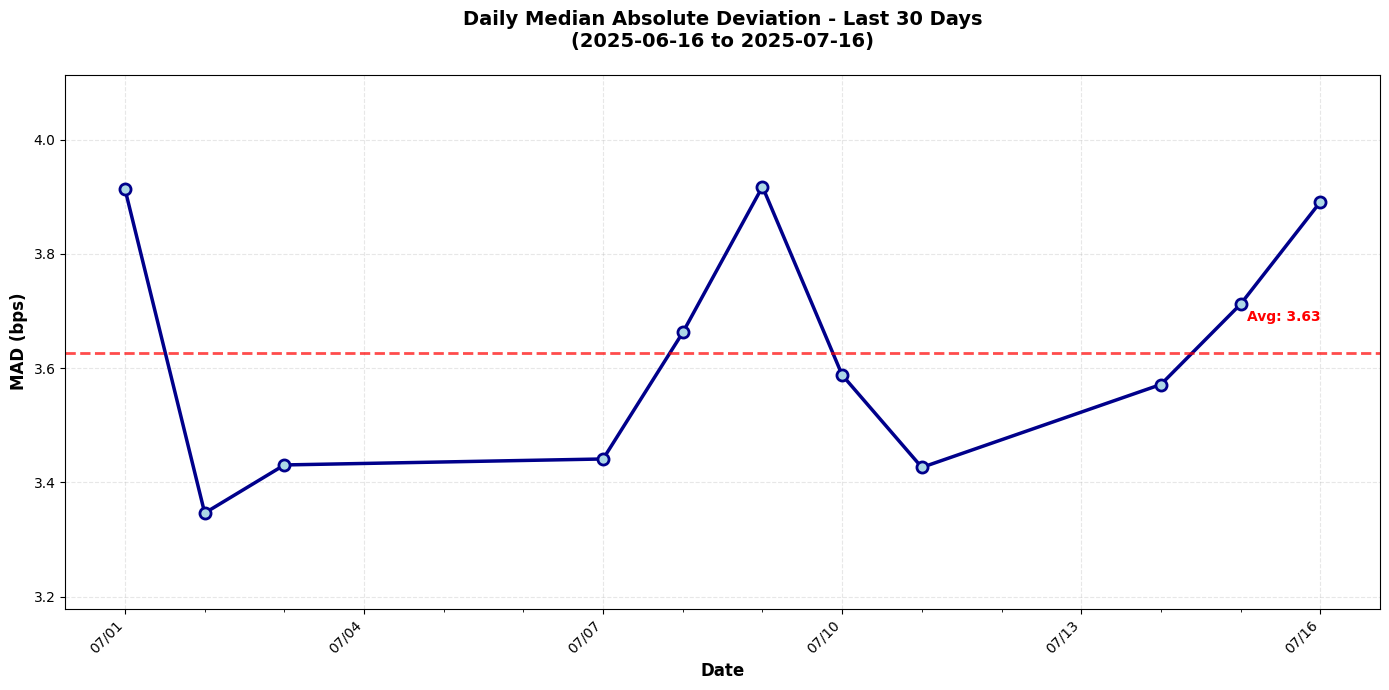


Summary Statistics (Last 30 Days):
Average MAD: 3.6270 bps
Median MAD: 3.5878 bps
Min MAD: 3.3462 bps on 2025-07-02
Max MAD: 3.9175 bps on 2025-07-09
Total trades: 64,080


In [59]:
# Calculate MAD by day for the last 30 days
# First, find the most recent date in the dataset
df_filtered['trade_date'] = pd.to_datetime(df_filtered['trade_date'])
max_date = df_filtered['trade_date'].max()
cutoff_date = max_date - pd.Timedelta(days=30)

# Filter for last 30 days
df_last30 = df_filtered[df_filtered['trade_date'] >= cutoff_date]

# Calculate MAD by day
daily_results = []
for date, group in df_last30.groupby(df_last30['trade_date'].dt.date):
    errors = group['new_ys'] - group['new_ys_prediction']
    median_error = errors.median()
    mad = (errors - median_error).abs().median()
    
    daily_results.append({
        'date': date,
        'mad': mad,
        'count': len(group)
    })
    
    print(f"{date}: MAD = {mad:.4f}, Count = {len(group)}")

mad_df = pd.DataFrame(daily_results)
mad_df['date'] = pd.to_datetime(mad_df['date'])

# Plot the results
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(mad_df['date'], mad_df['mad'], 
        'o-', linewidth=2.5, markersize=8, 
        color='darkblue', markerfacecolor='lightblue', 
        markeredgewidth=2, markeredgecolor='darkblue')

ax.set_ylabel('MAD (bps)', fontsize=12, fontweight='bold')
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_title(f'Daily Median Absolute Deviation - Last 30 Days\n({cutoff_date.strftime("%Y-%m-%d")} to {max_date.strftime("%Y-%m-%d")})', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')

# Format x-axis to show more dates
import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))  # Show every 3rd day
ax.xaxis.set_minor_locator(mdates.DayLocator())  # Show minor ticks for all days
plt.xticks(rotation=45, ha='right')

# Add average line
avg_mad = mad_df['mad'].mean()
ax.axhline(y=avg_mad, color='red', linestyle='--', alpha=0.7, linewidth=2)
ax.text(mad_df['date'].iloc[-1], avg_mad + 0.05, f'Avg: {avg_mad:.2f}', 
        ha='right', va='bottom', fontsize=10, fontweight='bold', color='red')

# Adjust y-axis limits for better visibility
y_min = mad_df['mad'].min() * 0.95
y_max = mad_df['mad'].max() * 1.05
ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics (Last 30 Days):")
print(f"Average MAD: {mad_df['mad'].mean():.4f} bps")
print(f"Median MAD: {mad_df['mad'].median():.4f} bps")
print(f"Min MAD: {mad_df['mad'].min():.4f} bps on {mad_df.loc[mad_df['mad'].idxmin(), 'date'].strftime('%Y-%m-%d')}")
print(f"Max MAD: {mad_df['mad'].max():.4f} bps on {mad_df.loc[mad_df['mad'].idxmax(), 'date'].strftime('%Y-%m-%d')}")
print(f"Total trades: {mad_df['count'].sum():,}")

In [19]:
# ── Optional: keep only rows where calc_date is ≥ trade_date + 1 year ──
# (you already have days_since_trade, so this is straightforward)
# df_filt = df[df["days_since_trade"] >= 365].copy()

# ── Step 1: errors ──
errors = df["new_ys"] - df["new_ys_prediction"]

# ── Step 2: median of errors ──
median_error = errors.median()          # identical to np.median(errors)

# ── Step 3: absolute deviations from that median ──
deviations = (errors - median_error).abs()

# ── Step 4: median of the deviations  →  MAD ──
mad = deviations.median()               # or np.median(deviations)

print(f"Median error: {median_error:.6f}")
print(f"MAD:          {mad:.6f}")


Median error: 0.977294
MAD:          5.463312
